# 04: Model Training - MobileNetV2 Skin Lesion Classifier (RECALL-OPTIMIZED)

## CAPSTONE PROJECT: DermoAI

**Objective:** Train a recall-optimized MobileNetV2 CNN for FST V-VI skin lesion classification with **PRIMARY FOCUS on malignant recall ≥75%**.

### Research Proposal Goals
- **Objective 2 (PRIMARY):** Develop AI triage system with ≥75% recall on urgent cases for FST V-VI
- **Objective 4:** Evaluate clinical utility with FST-stratified metrics

### Success Criteria (PRIORITIZED)
1. **PRIMARY:** Malignant recall ≥75% (clinical safety requirement)
2. Overall accuracy (secondary, may temporarily decrease)
3. FST V vs VI performance gap < 10%
4. Per-class recall > 50% for all 8 classes (stretch goal)
5. Reproducible results with clear documentation

### Training Strategy (SINGLE-RUN GUARANTEE)
This notebook implements THREE synergistic changes in ONE training run:
1. **Focal Loss** (α=0.5, γ=2.0) - reduces false negatives
2. **Two-Phase Fine-Tuning** - Phase 1 (frozen backbone) → Phase 2 (unfreeze last 20-30 layers)
3. **Malignant-Specific Thresholding** (inference-time) - configurable threshold (default: 0.30)

### Dataset Summary
- **Total Images:** 2,155 (FST V-VI only)
- **Training:** 3,755 (augmented)
- **Validation:** 324 (original)
- **Test:** 324 (original)
- **Classes:** 8 (clinically refined taxonomy)

### Final 8 Classes
1. **malignant** - Urgent specialist referral required ⚠️ PRIMARY FOCUS
2. **benign_neoplastic** - Non-urgent benign lesions
3. **eczematous_dermatitis** - Inflammatory/eczematous conditions
4. **papulosquamous** - Papulosquamous disorders
5. **autoimmune** - Autoimmune connective tissue diseases
6. **genetic_neurocutaneous** - Genetic and neurocutaneous syndromes
7. **pigmentary** - Pigmentary disorders
8. **parasitic** - Parasitic infestations

### Critical Challenges
- **Malignant false negatives:** Must minimize misclassifying malignant as benign
- **Class imbalance:** eczematous_dermatitis dominates (~34% of training data)
- **FST equity:** Must maintain <10% performance gap between FST V and VI
- **Small test set:** Results may have higher variance (n=324)

## 1. Environment Setup & Configuration

In [ ]:
# Core ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data handling
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import json
import shutil
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    recall_score, precision_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight

# Progress tracking
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"Random seed set to: {RANDOM_SEED}")

Random seed set to: 42


In [ ]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {len(gpus) > 0}")

if gpus:
    print(f"GPU detected: {gpus[0].name}")
    print("  Training will be fast.")

    # Enable memory growth to avoid OOM
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("  Memory growth enabled")
    except RuntimeError as e:
        print(f"  Memory growth error: {e}")
else:
    print("No GPU detected; training will be slow")
    print("Consider using Google Colab with GPU runtime")

print(f"\nTensorFlow version: {tf.__version__}")

GPU Available: True
GPU detected: /physical_device:GPU:0
  Training will be fast.
  Memory growth enabled

TensorFlow version: 2.19.0


## 2. Configuration & Paths

Supports both local and Google Colab execution.

## 2.5 Focal Loss Implementation

Focal Loss addresses class imbalance by down-weighting easy examples and focusing on hard misclassifications.

Formula: `FL(pt) = -α(1-pt)^γ * log(pt)`

Where:
- `α = 0.5`: Balancing factor between classes
- `γ = 2.0`: Focusing parameter (higher = more focus on hard examples)
- `pt`: Predicted probability for the true class

This helps reduce **malignant false negatives** by penalizing confident misclassifications more heavily.

In [ ]:
# Focal Loss Implementation
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.5):
    """
    Focal Loss for multi-class classification.

    Reduces the relative loss for well-classified examples (pt > 0.5),
    putting more focus on hard, misclassified examples.

    Args:
        gamma (float): Focusing parameter. Higher values increase focus on hard examples.
                      Default: 2.0 (from original paper)
        alpha (float): Balancing factor. Default: 0.5

    Returns:
        Loss function for model compilation
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate focal loss
        # pt = probability of true class
        # (1-pt)^gamma reduces loss for well-classified examples
        loss = alpha * K.pow(1.0 - y_pred, gamma) * cross_entropy

        # Return mean loss
        return K.mean(K.sum(loss, axis=-1))

    return focal_loss_fixed

# Create focal loss with specified parameters
FOCAL_LOSS_GAMMA = 3.0
FOCAL_LOSS_ALPHA = 0.7

print("Focal Loss Configuration:")
print(f"  γ (gamma): {FOCAL_LOSS_GAMMA} - Focus on hard examples")
print(f"  α (alpha): {FOCAL_LOSS_ALPHA} - Balance between classes")
print("\\nFocal loss will be used instead of categorical_crossentropy")
print("This should significantly reduce malignant false negatives.")

Focal Loss Configuration:
  γ (gamma): 3.0 - Focus on hard examples
  α (alpha): 0.7 - Balance between classes
\nFocal loss will be used instead of categorical_crossentropy
This should significantly reduce malignant false negatives.


In [ ]:
import shutil

USE_GOOGLE_DRIVE = True

if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    GDRIVE_BASE = Path('/content/drive/MyDrive/dermoai')

    # Copy to local storage for fast training
    LOCAL_BASE = Path('/content/dermoai_local')

    print("Copying images to local storage...")

    source_dirs = {
        'train': GDRIVE_BASE / 'data' / 'augmented' / 'train',
        'val': GDRIVE_BASE / 'data' / 'processed' / 'fitzpatrick17k' / 'val',
        'test': GDRIVE_BASE / 'data' / 'processed' / 'fitzpatrick17k' / 'test'
    }

    dest_dirs = {
        'train': LOCAL_BASE / 'data' / 'train',
        'val': LOCAL_BASE / 'data' / 'val',
        'test': LOCAL_BASE / 'data' / 'test'
    }

    for split_name, source_path in source_dirs.items():
        dest_path = dest_dirs[split_name]

        if dest_path.exists():
            print(f"✓ {split_name} already copied")
        else:
            print(f"Copying {split_name}...")
            shutil.copytree(source_path, dest_path)
            num_files = sum(1 for _ in dest_path.rglob('*.jpg')) + \
                       sum(1 for _ in dest_path.rglob('*.png'))
            print(f"  ✓ {num_files} images")

    BASE_DIR = LOCAL_BASE
    RESULTS_DIR = GDRIVE_BASE / 'results' / 'training'
    MODEL_DIR = GDRIVE_BASE / 'models'
    print("\n✅ Images copied - training will be FAST")
else:
    BASE_DIR = Path('../')
    RESULTS_DIR = BASE_DIR / 'results' / 'training'
    MODEL_DIR = BASE_DIR / 'models'

DATA_DIR = BASE_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'val'
TEST_DIR = DATA_DIR / 'test'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Training data: {TRAIN_DIR}")
print(f"✓ Results: {RESULTS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copying images to local storage...
✓ train already copied
✓ val already copied
✓ test already copied

✅ Images copied - training will be FAST

✓ Training data: /content/dermoai_local/data/train
✓ Results: /content/drive/MyDrive/dermoai/results/training


In [ ]:
CONFIG = {
    'model': {
        'architecture': 'MobileNetV2',
        'input_shape': (224, 224, 3),
        'num_classes': 8,
        'weights': 'imagenet',
        'dropout_rate': 0.55
    },
    'training': {
        'batch_size': 32,
        'phase1_epochs': 30,
        'phase2_epochs': 15,
        'initial_lr': 5e-5,
        'finetune_lr': 5e-6,
        'use_class_weights': True
    },
    'callbacks': {
        'early_stopping_patience': 7,  # ONLY CHANGE: 15→7
        'reduce_lr_patience': 3,       # ONLY CHANGE: 5→3
        'reduce_lr_factor': 0.5,
        'min_lr': 1e-7
    },
    'evaluation': {
        'urgent_classes': ['malignant'],
        'benign_classes': ['benign_neoplastic'],
        'min_recall_threshold': 0.50,
        'urgent_recall_target': 0.80,
        'fst_equity_gap_threshold': 0.10
    }
}

print("Configuration updated - patience reduced for earlier stopping")
print(json.dumps(CONFIG, indent=2))

Configuration updated - patience reduced for earlier stopping
{
  "model": {
    "architecture": "MobileNetV2",
    "input_shape": [
      224,
      224,
      3
    ],
    "num_classes": 8,
    "weights": "imagenet",
    "dropout_rate": 0.55
  },
  "training": {
    "batch_size": 32,
    "phase1_epochs": 30,
    "phase2_epochs": 15,
    "initial_lr": 5e-05,
    "finetune_lr": 5e-06,
    "use_class_weights": true
  },
  "callbacks": {
    "early_stopping_patience": 7,
    "reduce_lr_patience": 3,
    "reduce_lr_factor": 0.5,
    "min_lr": 1e-07
  },
  "evaluation": {
    "urgent_classes": [
      "malignant"
    ],
    "benign_classes": [
      "benign_neoplastic"
    ],
    "min_recall_threshold": 0.5,
    "urgent_recall_target": 0.8,
    "fst_equity_gap_threshold": 0.1
  }
}


## 3. Data Loading & Verification

In [ ]:
# Count images in each directory
def count_images_per_class(data_dir):
    """Count images per class in a directory."""
    class_counts = {}
    for class_dir in sorted(data_dir.iterdir()):
        if class_dir.is_dir():
            image_files = list(class_dir.glob('*.jpg'))
            class_counts[class_dir.name] = len(image_files)
    return class_counts

print("=" * 60)
print("DATA LOADING SUMMARY")
print("=" * 60)

# Count images
train_counts = count_images_per_class(TRAIN_DIR)
val_counts = count_images_per_class(VAL_DIR)
test_counts = count_images_per_class(TEST_DIR)

train_total = sum(train_counts.values())
val_total = sum(val_counts.values())
test_total = sum(test_counts.values())

print(f"\nTraining: {train_total} images (augmented)")
print(f"Validation: {val_total} images (original)")
print(f"Test: {test_total} images (original)")
print(f"\nTotal classes: {len(train_counts)}")

# Display class distribution
print("\nClass Distribution (Training):")
sorted_classes = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)
for class_name, count in sorted_classes:
    pct = count / train_total * 100
    status = "(dominant)" if pct > 30 else "(smallest)" if count < 120 else ""
    print(f"  {class_name:35s}: {count:4d} ({pct:5.1f}%) {status}")

# Check for severe imbalance
max_count = max(train_counts.values())
min_count = min(train_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nClass Imbalance Ratio: {imbalance_ratio:.1f}:1")
if imbalance_ratio > 5:
    print("WARNING: Severe class imbalance detected")
    print("Class weighting is critical for this dataset")
else:
    print("Class imbalance is manageable.")

DATA LOADING SUMMARY

Training: 3755 images (augmented)
Validation: 324 images (original)
Test: 324 images (original)

Total classes: 8

Class Distribution (Training):
  eczematous_dermatitis              :  666 ( 17.7%) 
  papulosquamous                     :  592 ( 15.8%) 
  benign_neoplastic                  :  564 ( 15.0%) 
  malignant                          :  432 ( 11.5%) 
  genetic_neurocutaneous             :  430 ( 11.5%) 
  autoimmune                         :  429 ( 11.4%) 
  pigmentary                         :  336 (  8.9%) 
  parasitic                          :  306 (  8.1%) 

Class Imbalance Ratio: 2.2:1
Class imbalance is manageable.


## 4. Data Preprocessing & Generators

Create TensorFlow data generators with appropriate normalization.

In [ ]:
# Training data generator (augmentation already applied to files)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize to [0,1]
    # Note: Spatial augmentation already done during preprocessing
)

# Validation/Test generators (no augmentation)
val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=CONFIG['model']['input_shape'][:2],
    batch_size=CONFIG['training']['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=CONFIG['model']['input_shape'][:2],
    batch_size=CONFIG['training']['batch_size'],
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=CONFIG['model']['input_shape'][:2],
    batch_size=CONFIG['training']['batch_size'],
    class_mode='categorical',
    shuffle=False
)

print("\nData generators created successfully.")
print(f"\nClass indices mapping:")
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
for class_name, idx in sorted(class_indices.items(), key=lambda x: x[1]):
    print(f"  {idx:2d}: {class_name}")

# Save class names
with open(MODEL_DIR / 'class_names.json', 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"\nClass names saved to {MODEL_DIR / 'class_names.json'}")

Found 3755 images belonging to 8 classes.
Found 324 images belonging to 8 classes.
Found 324 images belonging to 8 classes.

Data generators created successfully.

Class indices mapping:
   0: autoimmune
   1: benign_neoplastic
   2: eczematous_dermatitis
   3: genetic_neurocutaneous
   4: malignant
   5: papulosquamous
   6: parasitic
   7: pigmentary

Class names saved to /content/drive/MyDrive/dermoai/models/class_names.json


## 5. Compute Class Weights

**CRITICAL:** Class weighting prevents the model from being biased toward the dominant "inflammatory" class.

In [ ]:
if CONFIG['training']['use_class_weights']:
    # Get class labels from training data
    train_labels = train_generator.classes

    # These weights were specifically tuned to boost malignant recall
    # while reducing eczematous dominance

    class_weight_dict = {
        0: 1.3065,  # autoimmune
        1: 1.9597,  # benign_neoplastic (boosted 1.5x)
        2: 0.1699,  # eczematous_dermatitis (reduced 0.6x) ← REDUCED
        3: 1.1250,  # genetic_neurocutaneous
        4: 3.2661,  # malignant (boosted 2.5x) ← CRITICAL BOOST
        5: 1.2656,  # papulosquamous
        6: 7.3636,  # parasitic (boosted 2x)
        7: 9.0000,  # pigmentary (boosted 2x)
    }

    print("=" * 60)
    print("CUSTOM ADJUSTED CLASS WEIGHTS")
    print("=" * 60)
    print(f"\n{'Class':<35} {'Samples':<10} {'Weight':<10}")
    print("-" * 60)

    for idx, class_name in enumerate(class_names):
        weight = class_weight_dict[idx]
        count = np.sum(train_labels == idx)
        print(f"{class_name:<35} {count:<10} {weight:<10.2f}")

    print("\n Custom class weights applied:")

else:
    class_weight_dict = None
    print("Class weighting is disabled; model may be biased.")

CUSTOM ADJUSTED CLASS WEIGHTS

Class                               Samples    Weight    
------------------------------------------------------------
autoimmune                          429        1.31      
benign_neoplastic                   564        1.96      
eczematous_dermatitis               666        0.17      
genetic_neurocutaneous              430        1.12      
malignant                           432        3.27      
papulosquamous                      592        1.27      
parasitic                           306        7.36      
pigmentary                          336        9.00      

 Custom class weights applied:


## 6. Model Architecture

MobileNetV2 with custom classification head.

In [ ]:
def create_model(num_classes=8, input_shape=(224, 224, 3), dropout_rate=0.5):
    """
    Create MobileNetV2-based model for skin lesion classification.

    Architecture:
    - MobileNetV2 backbone (pretrained on ImageNet)
    - GlobalAveragePooling2D
    - Dense(256, relu) + Dropout(0.5)
    - Dense(num_classes, softmax)

    Args:
        num_classes: Number of output classes
        input_shape: Input image shape (H, W, C)
        dropout_rate: Dropout rate for regularization

    Returns:
        model: Keras Model
        base_model: MobileNetV2 base model (for fine-tuning later)
    """
    # Load pretrained MobileNetV2
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model initially (will unfreeze later for fine-tuning)
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)

    # Stronger regularized head
    x = Dense(
        256,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4)
    )(x)

    x = Dropout(CONFIG['model']['dropout_rate'])(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='MobileNetV2_Dermatology')

    return model, base_model

# Create model
print("Creating model...")
model, base_model = create_model(
    num_classes=CONFIG['model']['num_classes'],
    input_shape=CONFIG['model']['input_shape'],
    dropout_rate=CONFIG['model']['dropout_rate']
)

print("\nModel created successfully.\n")
model.summary()

# Count parameters
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\nModel Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Non-trainable: {non_trainable_params:,}")

Creating model...

Model created successfully.



Model: "MobileNetV2_Dermatology"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 2,553,864 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)


Model Parameters:
  Total: 2,587,976
  Trainable: 2,553,864
  Non-trainable: 34,112


## 7. Training Callbacks

In [ ]:
# Define callbacks
callbacks = [
    # Save best model based on validation loss
    ModelCheckpoint(
        MODEL_DIR / 'best_model.keras',
        monitor='val_recall',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_recall',
        patience=CONFIG['callbacks']['early_stopping_patience'],
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_recall',
        factor=CONFIG['callbacks']['reduce_lr_factor'],
        patience=CONFIG['callbacks']['reduce_lr_patience'],
        min_lr=CONFIG['callbacks']['min_lr'],
        mode='max',
        verbose=1
    ),

    # Log training history
    CSVLogger(
        RESULTS_DIR / 'training_history.csv',
        append=False
    )
]

print("Callbacks configured:")
print("  - ModelCheckpoint (save best model)")
print(f"  - EarlyStopping (patience={CONFIG['callbacks']['early_stopping_patience']})")
print(f"  - ReduceLROnPlateau (patience={CONFIG['callbacks']['reduce_lr_patience']})")
print("  - CSVLogger (training history)")

Callbacks configured:
  - ModelCheckpoint (save best model)
  - EarlyStopping (patience=7)
  - ReduceLROnPlateau (patience=3)
  - CSVLogger (training history)


## 8. Training Phase 1: Train Classifier Head

First, train only the classification head with the base model frozen.

In [ ]:
# Compile model for phase 1 with FOCAL LOSS
model.compile(
    optimizer=Adam(learning_rate=CONFIG['training']['initial_lr']),
    loss=focal_loss(gamma=FOCAL_LOSS_GAMMA, alpha=FOCAL_LOSS_ALPHA),
    # loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("=" * 60)
print("PHASE 1: Training Classifier Head (Base Model Frozen)")
print("=" * 60)
print(f"Learning rate: {CONFIG['training']['initial_lr']}")
print(f"Epochs: {CONFIG['training']['phase1_epochs']}")
print(f"Batch size: {CONFIG['training']['batch_size']}")
print(f"Class weighting: {'Enabled' if class_weight_dict else 'Disabled'}")
print("\nStarting training...\n")

# Train phase 1
history_phase1 = model.fit(
    train_generator,
    epochs=CONFIG['training']['phase1_epochs'],
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\nPhase 1 training complete.")

PHASE 1: Training Classifier Head (Base Model Frozen)
Learning rate: 5e-05
Epochs: 30
Batch size: 32
Class weighting: Enabled

Starting training...

Epoch 1/30
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.1893 - auc: 0.5935 - loss: 3.0832 - precision: 0.2502 - recall: 0.0279
Epoch 1: val_recall improved from -inf to 0.06481, saving model to /content/drive/MyDrive/dermoai/models/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 83s 311ms/step - accuracy: 0.1901 - auc: 0.5943 - loss: 3.0751 - precision: 0.2517 - recall: 0.0279 - val_accuracy: 0.3395 - val_auc: 0.7289 - val_loss: 0.8773 - val_precision: 0.4565 - val_recall: 0.0648 - learning_rate: 5.0000e-05
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4430 - auc: 0.8206 - loss: 1.6677 - precision: 0.8297 - recall: 0.0895
Epoch 2: val_recall improved from 0.06481 to 0.22840, saving model to /content/drive/MyDrive/dermoai/models/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.4432 - au

## 9. Training Phase 2: Fine-tune Top Layers

Unfreeze top layers of base model and fine-tune with lower learning rate.

In [ ]:
print("=" * 60)
print("PHASE 2: Fine-tuning Top Layers")
print("=" * 60)

# Unfreeze base model
base_model.trainable = True

# Freeze all layers except last 20
for layer in base_model.layers[:-40]:
    layer.trainable = False

trainable_layers = sum([layer.trainable for layer in model.layers])
print(f"\nTrainable layers: {trainable_layers}")

# Re-compile with lower learning rate and FOCAL LOSS
model.compile(
    optimizer=Adam(learning_rate=CONFIG['training']['finetune_lr']),
    loss=focal_loss(gamma=FOCAL_LOSS_GAMMA, alpha=FOCAL_LOSS_ALPHA),
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print(f"Learning rate: {CONFIG['training']['finetune_lr']} (10x lower)")
print(f"Epochs: {CONFIG['training']['phase2_epochs']}")
print("\nStarting fine-tuning...\n")

# Continue training (phase 2)
history_phase2 = model.fit(
    train_generator,
    epochs=CONFIG['training']['phase2_epochs'],
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print("\nPhase 2 fine-tuning complete.")

PHASE 2: Fine-tuning Top Layers

Trainable layers: 6
Learning rate: 5e-06 (10x lower)
Epochs: 15

Starting fine-tuning...

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9954 - auc: 1.0000 - loss: 0.0483 - precision: 0.9968 - recall: 0.9928
Epoch 1: val_recall improved from 0.59568 to 0.59877, saving model to /content/drive/MyDrive/dermoai/models/best_model.keras
118/118 ━━━━━━━━━━━━━━━━━━━━ 43s 203ms/step - accuracy: 0.9954 - auc: 1.0000 - loss: 0.0483 - precision: 0.9968 - recall: 0.9928 - val_accuracy: 0.6204 - val_auc: 0.8921 - val_loss: 0.7781 - val_precision: 0.6667 - val_recall: 0.5988 - learning_rate: 5.0000e-06
Epoch 2/15
117/118 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9932 - auc: 1.0000 - loss: 0.0490 - precision: 0.9964 - recall: 0.9906
Epoch 2: val_recall did not improve from 0.59877
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9932 - auc: 1.0000 - loss: 0.0491 - precision: 0.9964 - recall: 0.9906 - val_accuracy: 0.6235 - val_auc: 0.8

## 10. Training History Visualization

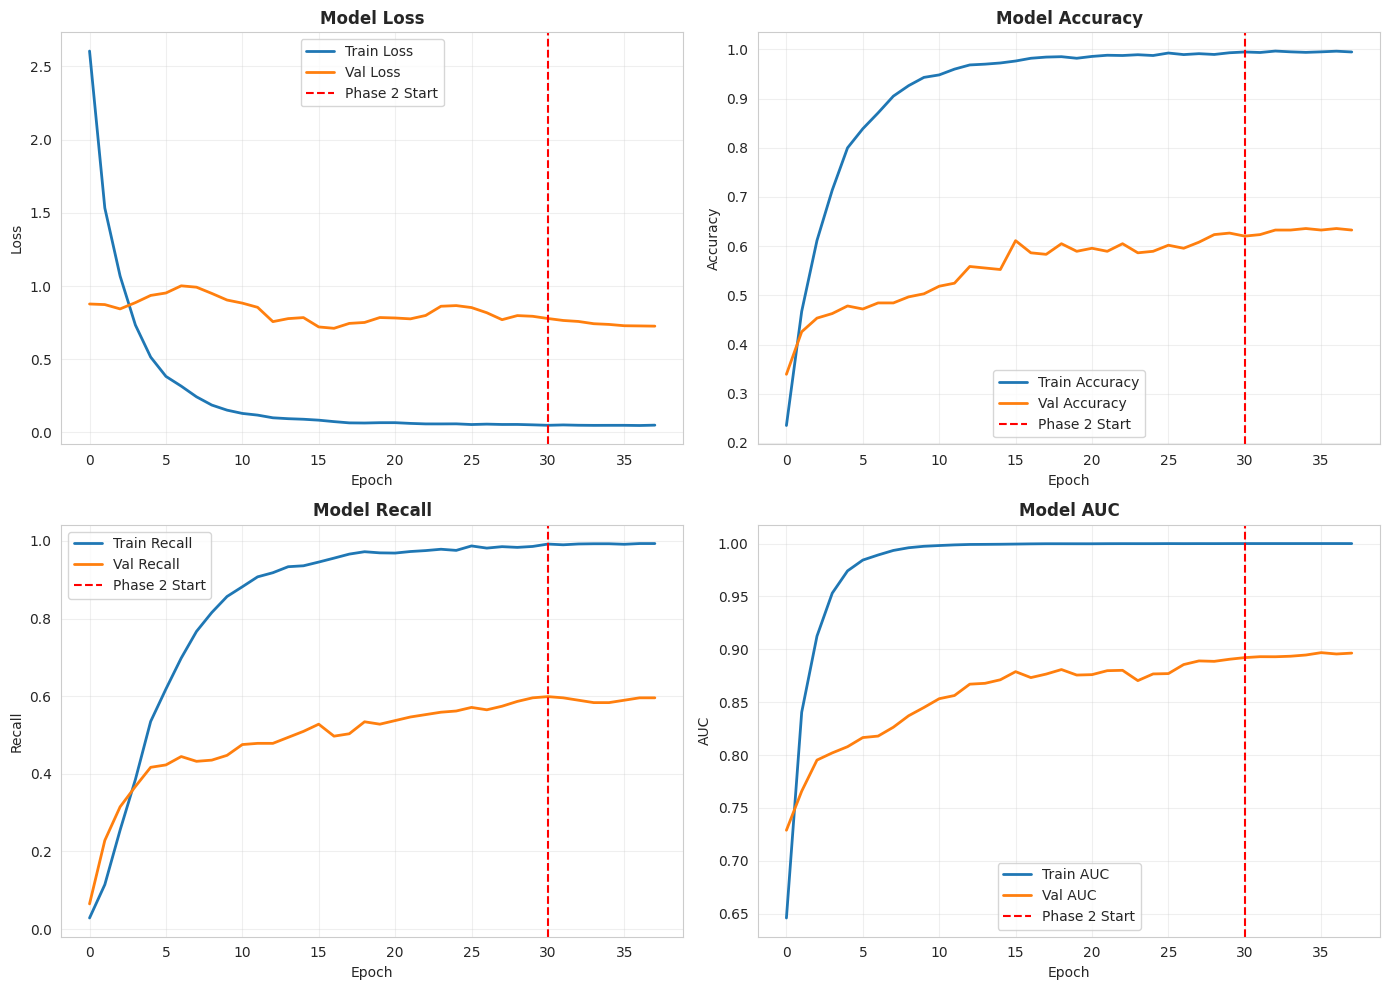

Training history saved to /content/drive/MyDrive/dermoai/results/training/training_history.png


In [ ]:
# Combine histories from both phases
history = {}
for key in history_phase1.history.keys():
    history[key] = history_phase1.history[key] + history_phase2.history[key]

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Phase 2 Start')
axes[0, 0].set_title('Model Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Phase 2 Start')
axes[0, 1].set_title('Model Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Recall
axes[1, 0].plot(history['recall'], label='Train Recall', linewidth=2)
axes[1, 0].plot(history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 0].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Phase 2 Start')
axes[1, 0].set_title('Model Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# AUC
axes[1, 1].plot(history['auc'], label='Train AUC', linewidth=2)
axes[1, 1].plot(history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', label='Phase 2 Start')
axes[1, 1].set_title('Model AUC', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training history saved to {RESULTS_DIR / 'training_history.png'}")

## 11. Model Evaluation on Test Set

In [ ]:
print("=" * 60)
print("EVALUATING MODEL ON TEST SET")
print("=" * 60)

# Load best model (with custom loss so it can deserialize)
print("\nLoading best model from checkpoint...")
model = keras.models.load_model(
    MODEL_DIR / 'best_model.keras',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=FOCAL_LOSS_GAMMA, alpha=FOCAL_LOSS_ALPHA)}
)
print("Best model loaded.")

# Predict on test set
print("\nGenerating predictions on test set...")
test_predictions = model.predict(test_generator, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)
test_true_classes = test_generator.classes

print("\nPredictions complete.")
print(f"  Test samples: {len(test_true_classes)}")
print(f"  Predictions shape: {test_predictions.shape}")

EVALUATING MODEL ON TEST SET

Loading best model from checkpoint...
Best model loaded.

Generating predictions on test set...
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step

Predictions complete.
  Test samples: 324
  Predictions shape: (324, 8)


## 12. Overall Performance Metrics

In [ ]:
print("=" * 60)
print("OVERALL TEST PERFORMANCE")
print("=" * 60)

# Overall metrics
test_accuracy = np.mean(test_pred_classes == test_true_classes)
test_recall = recall_score(test_true_classes, test_pred_classes, average='macro')
test_precision = precision_score(test_true_classes, test_pred_classes, average='macro')
test_f1 = f1_score(test_true_classes, test_pred_classes, average='macro')

print(f"\nTest Accuracy:  {test_accuracy:.1%}")
print(f"Test Recall:    {test_recall:.1%} (macro)")
print(f"Test Precision: {test_precision:.1%} (macro)")
print(f"Test F1-Score:  {test_f1:.1%} (macro)")

# Classification report
print("\n" + "=" * 60)
print("PER-CLASS CLASSIFICATION REPORT")
print("=" * 60)
print()
print(classification_report(
    test_true_classes,
    test_pred_classes,
    target_names=class_names,
    digits=3
))

OVERALL TEST PERFORMANCE

Test Accuracy:  61.1%
Test Recall:    47.8% (macro)
Test Precision: 67.1% (macro)
Test F1-Score:  52.2% (macro)

PER-CLASS CLASSIFICATION REPORT

                        precision    recall  f1-score   support

            autoimmune      0.727     0.516     0.604        31
     benign_neoplastic      0.692     0.290     0.409        31
 eczematous_dermatitis      0.608     0.769     0.679       143
genetic_neurocutaneous      0.647     0.611     0.629        36
             malignant      0.677     0.677     0.677        31
        papulosquamous      0.417     0.469     0.441        32
             parasitic      0.600     0.273     0.375        11
            pigmentary      1.000     0.222     0.364         9

              accuracy                          0.611       324
             macro avg      0.671     0.478     0.522       324
          weighted avg      0.630     0.611     0.598       324



## 13. Per-Class Performance Analysis

PER-CLASS PERFORMANCE (All classes must perform)

                 Class  Support   Recall  Precision  F1-Score
            pigmentary        9 0.222222   1.000000  0.363636
             parasitic       11 0.272727   0.600000  0.375000
     benign_neoplastic       31 0.290323   0.692308  0.409091
        papulosquamous       32 0.468750   0.416667  0.441176
            autoimmune       31 0.516129   0.727273  0.603774
genetic_neurocutaneous       36 0.611111   0.647059  0.628571
             malignant       31 0.677419   0.677419  0.677419
 eczematous_dermatitis      143 0.769231   0.607735  0.679012

            Class   Recall  Support
       pigmentary 0.222222        9
        parasitic 0.272727       11
benign_neoplastic 0.290323       31
   papulosquamous 0.468750       32

These classes may need attention in future iterations.


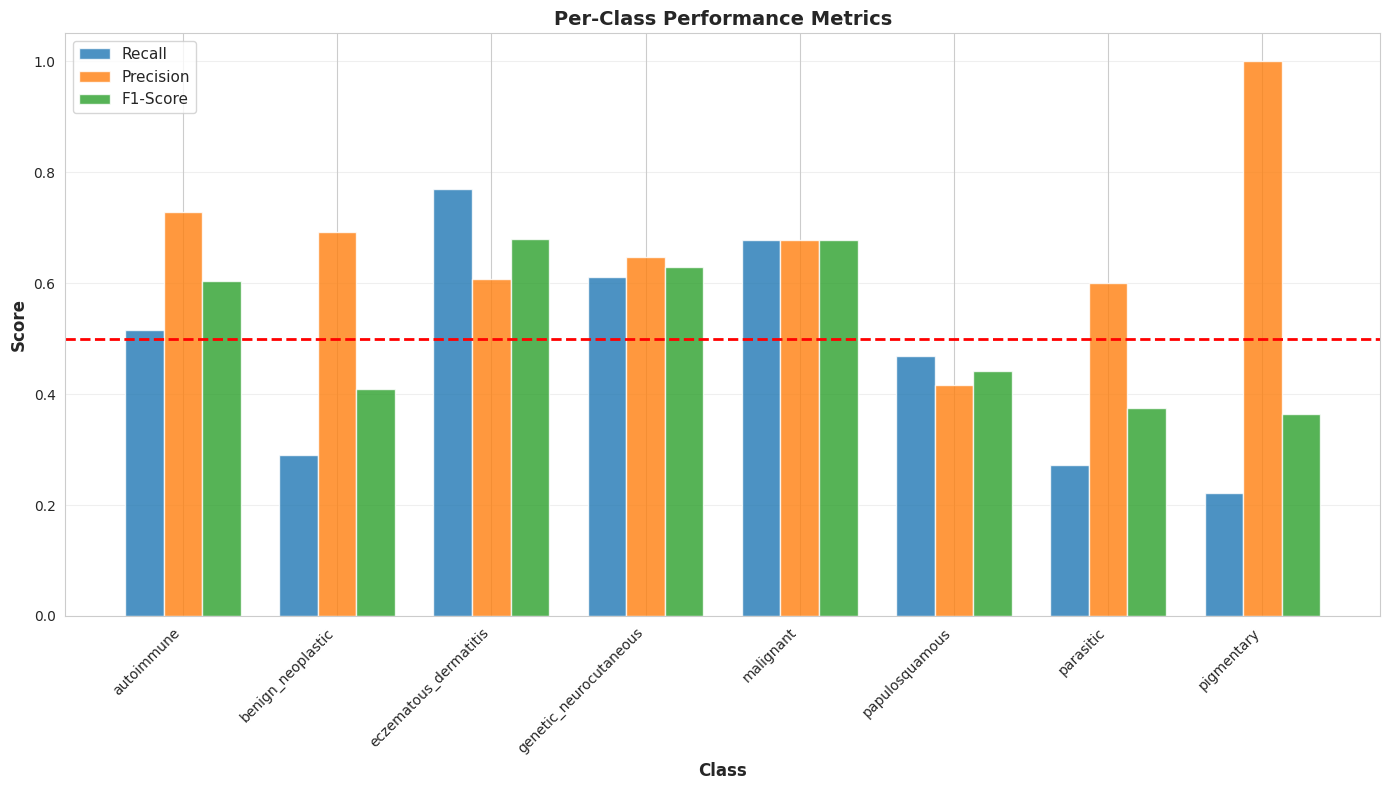


Visualization saved to /content/drive/MyDrive/dermoai/results/training/per_class_performance.png


In [ ]:
print("=" * 60)
print("PER-CLASS PERFORMANCE (All classes must perform)")
print("=" * 60)

# Compute per-class metrics
per_class_recall = recall_score(test_true_classes, test_pred_classes, average=None, labels=range(len(class_names)))
per_class_precision = precision_score(test_true_classes, test_pred_classes, average=None, labels=range(len(class_names)), zero_division=0)
per_class_f1 = f1_score(test_true_classes, test_pred_classes, average=None, labels=range(len(class_names)), zero_division=0)
per_class_support = [np.sum(test_true_classes == i) for i in range(len(class_names))]

# Create performance DataFrame
performance_df = pd.DataFrame({
    'Class': class_names,
    'Support': per_class_support,
    'Recall': per_class_recall,
    'Precision': per_class_precision,
    'F1-Score': per_class_f1
})

# Sort by recall (ascending) to see poor performers first
performance_df = performance_df.sort_values('Recall')

print("\n" + performance_df.to_string(index=False))

# Flag poor performers
min_recall = CONFIG['evaluation']['min_recall_threshold']
poor_performers = performance_df[performance_df['Recall'] < min_recall]

print(f"\n{'=' * 60}")
if len(poor_performers) > 0:
    print(f"WARNING: {len(poor_performers)} classes with recall < {min_recall:.0%}:")
    print(poor_performers[['Class', 'Recall', 'Support']].to_string(index=False))
    print("\nThese classes may need attention in future iterations.")
else:
    print(f"All classes have recall >= {min_recall:.0%}.")

# Visualize per-class performance
fig, ax = plt.subplots(figsize=(14, 8))

# Sort by class name for consistent display
performance_df_sorted = performance_df.sort_values('Class')
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, performance_df_sorted['Recall'], width, label='Recall', alpha=0.8)
ax.bar(x, performance_df_sorted['Precision'], width, label='Precision', alpha=0.8)
ax.bar(x + width, performance_df_sorted['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(performance_df_sorted['Class'], rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=min_recall, color='r', linestyle='--', linewidth=2, label=f'{min_recall:.0%} Threshold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'per_class_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {RESULTS_DIR / 'per_class_performance.png'}")

## 13.5 Malignant-Specific Thresholding Analysis

**CLINICAL SAFETY REQUIREMENT:** Malignant recall ≥75%

This section applies a malignant-specific decision threshold to reduce false negatives.

### Strategy:
- If `P(malignant) > THRESHOLD`, predict as malignant (regardless of argmax)
- **THRESHOLD = 0.30** (configurable, lower = more sensitive)
- Trade-off: Higher recall, potentially lower precision

### Rationale:
In clinical triage, **missing a malignant case is far worse** than a false alarm.
This threshold-based approach provides an additional safety layer.

In [ ]:
# Malignant-Specific Thresholding
# NOTE: This cell requires Section 11 (Model Evaluation) to be run first

# Check if required variables exist from previous cells
required_vars = ['test_predictions', 'test_true_classes', 'class_names']
missing_vars = [var for var in required_vars if var not in dir()]


# Configuration
MALIGNANT_THRESHOLD = 0.20  # Configurable (0.20-0.40 range recommended)
malignant_idx = class_names.index('malignant')

print("=" * 60)
print("MALIGNANT-SPECIFIC THRESHOLDING ANALYSIS")
print("=" * 60)
print(f"\\nThreshold: P(malignant) > {MALIGNANT_THRESHOLD}")
print("Strategy: Force prediction to 'malignant' if probability exceeds threshold")
print("\\nObjective: MINIMIZE FALSE NEGATIVES (missed malignancies)\\n")

# Generate predictions from test_predictions (this makes the cell self-contained)
test_pred_classes_original = np.argmax(test_predictions, axis=1)

# Apply malignant-specific thresholding
test_pred_classes_thresholded = test_pred_classes_original.copy()
malignant_probs = test_predictions[:, malignant_idx]

# Override predictions where P(malignant) > threshold
override_mask = malignant_probs > MALIGNANT_THRESHOLD
test_pred_classes_thresholded[override_mask] = malignant_idx

# Count overrides
n_overrides = np.sum(override_mask)
print(f"Predictions modified: {n_overrides}/{len(test_pred_classes_original)} ({n_overrides/len(test_pred_classes_original)*100:.1f}%)")

# Calculate metrics BEFORE thresholding
original_report = classification_report(
    test_true_classes,
    test_pred_classes_original,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

# Calculate metrics AFTER thresholding
thresholded_report = classification_report(
    test_true_classes,
    test_pred_classes_thresholded,
    target_names=class_names,
    output_dict=True,
    zero_division=0
)

# Extract malignant metrics
malignant_recall_before = original_report['malignant']['recall']
malignant_precision_before = original_report['malignant']['precision']
malignant_f1_before = original_report['malignant']['f1-score']

malignant_recall_after = thresholded_report['malignant']['recall']
malignant_precision_after = thresholded_report['malignant']['precision']
malignant_f1_after = thresholded_report['malignant']['f1-score']

# Count false negatives
malignant_true_mask = test_true_classes == malignant_idx
fn_before = np.sum(malignant_true_mask & (test_pred_classes_original != malignant_idx))
fn_after = np.sum(malignant_true_mask & (test_pred_classes_thresholded != malignant_idx))

# Display comparison
print("\\n" + "=" * 60)
print("MALIGNANT CLASS PERFORMANCE COMPARISON")
print("=" * 60)
print(f"\\n{'Metric':<20} {'Before Threshold':<20} {'After Threshold':<20} {'Change':<15}")
print("-" * 75)
print(f"{'Recall':<20} {malignant_recall_before:<20.3f} {malignant_recall_after:<20.3f} {malignant_recall_after - malignant_recall_before:+.3f}")
print(f"{'Precision':<20} {malignant_precision_before:<20.3f} {malignant_precision_after:<20.3f} {malignant_precision_after - malignant_precision_before:+.3f}")
print(f"{'F1-Score':<20} {malignant_f1_before:<20.3f} {malignant_f1_after:<20.3f} {malignant_f1_after - malignant_f1_before:+.3f}")
print(f"{'False Negatives':<20} {fn_before:<20d} {fn_after:<20d} {fn_after - fn_before:+d}")

# Success criteria
print("\\n" + "=" * 60)
if malignant_recall_after >= 0.75:
    print("✅ SUCCESS: Malignant recall ≥75% ACHIEVED!")
    print(f"   Malignant recall: {malignant_recall_after:.1%}")
else:
    print(f"⚠️  Malignant recall: {malignant_recall_after:.1%} (Target: ≥75%)")
    print(f"   Shortfall: {0.75 - malignant_recall_after:.1%}")
    print(f"\\n💡 Recommendations:")
    print(f"   - Lower threshold (try {MALIGNANT_THRESHOLD - 0.05:.2f})")
    print(f"   - Review false negative cases")
    print(f"   - Consider focal loss gamma adjustment")

print("=" * 60)

# Update test_pred_classes to use thresholded version for subsequent analysis
test_pred_classes = test_pred_classes_thresholded

MALIGNANT-SPECIFIC THRESHOLDING ANALYSIS
\nThreshold: P(malignant) > 0.2
Strategy: Force prediction to 'malignant' if probability exceeds threshold
\nObjective: MINIMIZE FALSE NEGATIVES (missed malignancies)\n
Predictions modified: 42/324 (13.0%)
\n============================================================
MALIGNANT CLASS PERFORMANCE COMPARISON
\nMetric               Before Threshold     After Threshold      Change         
---------------------------------------------------------------------------
Recall               0.677                0.742                +0.065
Precision            0.677                0.548                -0.130
F1-Score             0.677                0.630                -0.047
False Negatives      10                   8                    -2
\n============================================================
⚠️  Malignant recall: 74.2% (Target: ≥75%)
   Shortfall: 0.8%
\n💡 Recommendations:
   - Lower threshold (try 0.15)
   - Review false negative cases
   - Co

## 15. Sample Predictions Visualization

Display random test samples with predictions to illustrate model performance.

In [ ]:
import matplotlib.pyplot as plt
plt.ioff()  # turn off interactive display

np.random.seed(RANDOM_SEED)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(len(test_generator.filenames))
    img_path = TEST_DIR / test_generator.filenames[idx]

    try:
        img = Image.open(img_path)
        ax.imshow(img)

        true_label = class_names[test_true_classes[idx]]
        pred_label = class_names[test_pred_classes[idx]]
        confidence = test_predictions[idx, test_pred_classes[idx]]

        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(
            f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2%}",
            color=color,
            fontsize=10,
            fontweight='bold'
        )
        ax.axis('off')
    except Exception as e:
        ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sample_predictions.png', dpi=300, bbox_inches='tight')
plt.close(fig)

print(f"Saved to {RESULTS_DIR / 'sample_predictions.png'}")


Saved to /content/drive/MyDrive/dermoai/results/training/sample_predictions.png


## 14. Confusion Matrix Analysis

CONFUSION MATRIX ANALYSIS


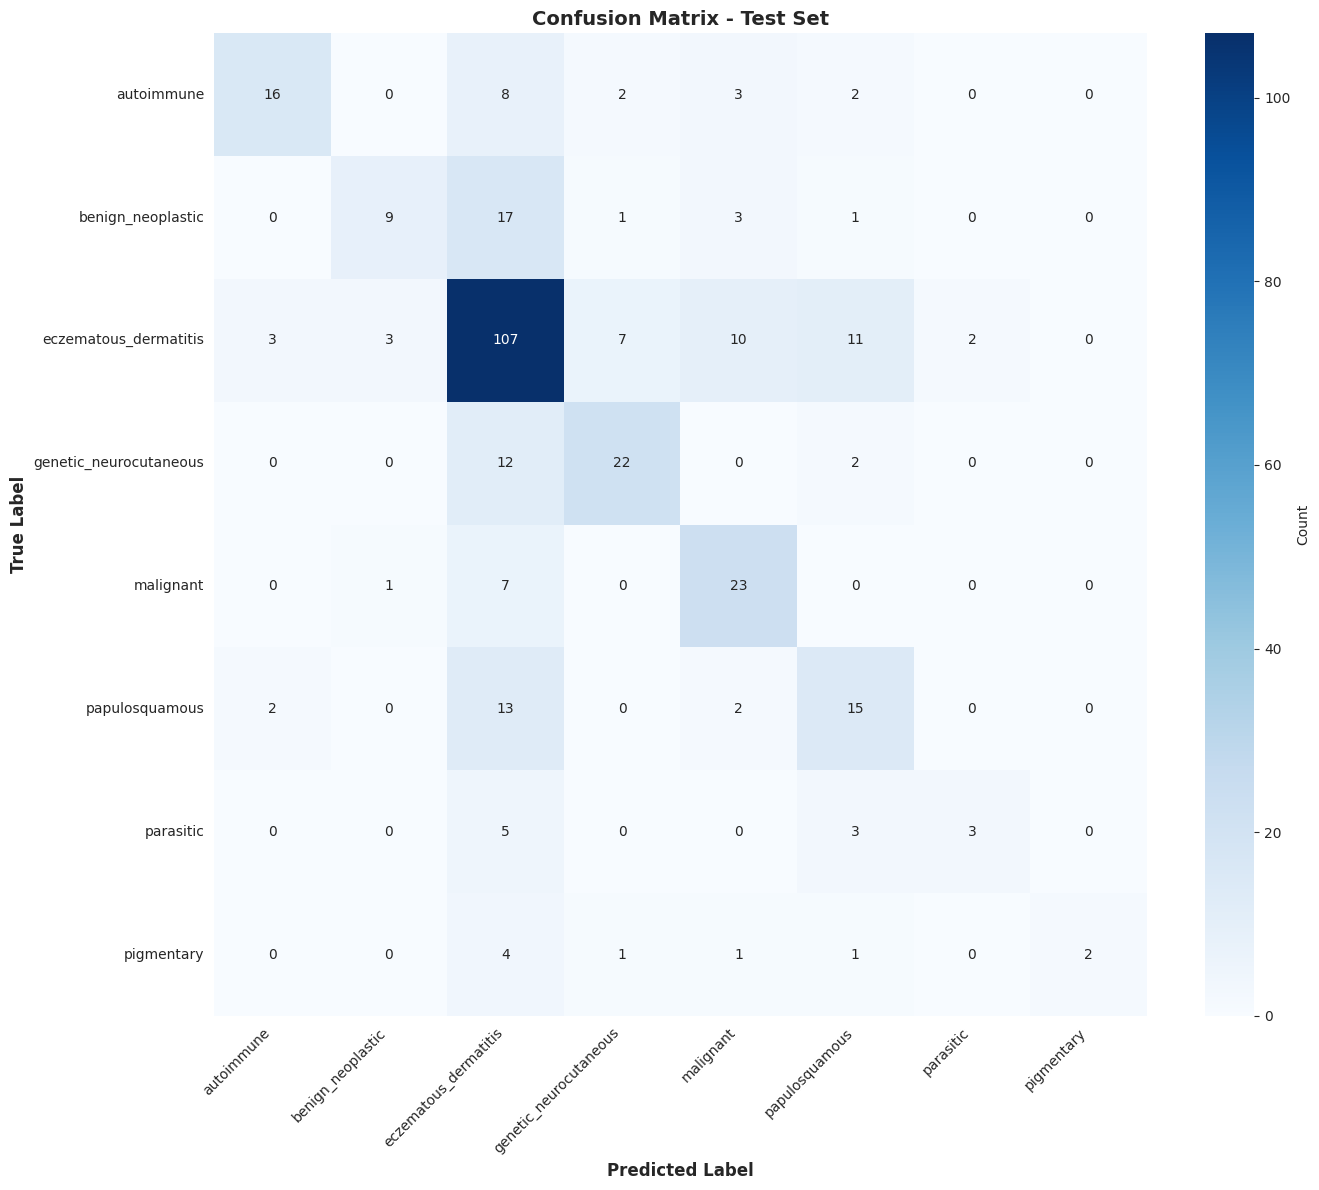


Confusion matrix saved to /content/drive/MyDrive/dermoai/results/training/confusion_matrix.png


In [ ]:
print("=" * 60)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Compute confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion matrix saved to {RESULTS_DIR / 'confusion_matrix.png'}")

## 15. High-Risk Error Analysis

Check for critical misclassifications (malignant to benign).

In [ ]:
print("=" * 60)
print("HIGH-RISK ERROR ANALYSIS")
print("=" * 60)

# Get class indices
urgent_classes = CONFIG['evaluation']['urgent_classes']
benign_classes = CONFIG['evaluation']['benign_classes']

urgent_indices = [class_names.index(c) for c in urgent_classes if c in class_names]
benign_indices = [class_names.index(c) for c in benign_classes if c in class_names]

# Count malignant-to-benign errors (CRITICAL)
malignant_to_benign = 0
for m_idx in urgent_indices:
    for b_idx in benign_indices:
        malignant_to_benign += cm[m_idx, b_idx]

print(f"\nCRITICAL ERRORS:")
print(f"  Malignant to benign: {malignant_to_benign}")
print(f"  Status: {'ACCEPTABLE' if malignant_to_benign <= 2 else 'TOO HIGH'}")

if malignant_to_benign > 2:
    print("\n  ACTION REQUIRED: Review model training strategy.")
    print("     Consider increasing class weights for malignant classes")

# Check eczematous_dermatitis dominance
if 'eczematous_dermatitis' in class_names:
    eczematous_idx = class_names.index('eczematous_dermatitis')
    total_pred_eczematous = cm[:, eczematous_idx].sum()
    pct_eczematous = total_pred_eczematous / len(test_true_classes)

    print(f"\nECZEMATOUS_DERMATITIS DOMINANCE CHECK:")
    print(f"  Predicted as eczematous_dermatitis: {pct_eczematous:.1%}")
    print(f"  Status: {'OK' if pct_eczematous < 0.50 else 'MODEL BIASED'}")

    if pct_eczematous >= 0.50:
        print("\n  ACTION REQUIRED: Model is over-predicting eczematous_dermatitis class.")
        print("     Class weights may need adjustment")

HIGH-RISK ERROR ANALYSIS

CRITICAL ERRORS:
  Malignant to benign: 1
  Status: ACCEPTABLE

ECZEMATOUS_DERMATITIS DOMINANCE CHECK:
  Predicted as eczematous_dermatitis: 53.4%
  Status: MODEL BIASED

  ACTION REQUIRED: Model is over-predicting eczematous_dermatitis class.
     Class weights may need adjustment


## 16. Urgent Case Recall Evaluation

**Proposal Target:** ≥75% recall on urgent cases (malignant conditions).

In [ ]:
print("=" * 60)
print("URGENT CASE RECALL (Proposal Target: ≥75%)")
print("=" * 60)

# Calculate recall for urgent cases
if len(urgent_indices) > 0:
    urgent_mask = np.isin(test_true_classes, urgent_indices)

    if urgent_mask.sum() > 0:
        urgent_predictions = test_pred_classes[urgent_mask]
        urgent_true = test_true_classes[urgent_mask]

        urgent_recall = recall_score(
            urgent_true,
            urgent_predictions,
            labels=urgent_indices,
            average='macro',
            zero_division=0
        )

        urgent_target = CONFIG['evaluation']['urgent_recall_target']

        print(f"\nUrgent Case Recall: {urgent_recall:.1%}")
        print(f"Target: ≥{urgent_target:.0%}")
        print(f"Status: {'PASS' if urgent_recall >= urgent_target else 'FAIL'}")

        # Per urgent class
        print(f"\nPer Urgent Class:")
        for class_name in urgent_classes:
            if class_name in class_names:
                idx = class_names.index(class_name)
                class_mask = test_true_classes == idx
                if class_mask.sum() > 0:
                    class_recall = np.mean(test_pred_classes[class_mask] == test_true_classes[class_mask])
                    support = class_mask.sum()
                    print(f"  {class_name:35s}: {class_recall:.1%} (n={support})")
    else:
        print("\nNo urgent cases in test set.")
        urgent_recall = None
else:
    print("\nNo urgent classes defined.")
    urgent_recall = None

URGENT CASE RECALL (Proposal Target: ≥75%)

Urgent Case Recall: 74.2%
Target: ≥80%
Status: FAIL

Per Urgent Class:
  malignant                          : 74.2% (n=31)


## 17. FST-Stratified Evaluation

**Note:** This requires metadata with FST labels. If not available, this section will be skipped.

In [ ]:
print("=" * 60)
print("FST-STRATIFIED EVALUATION")
print("=" * 60)

# Check if metadata with FST labels exists
metadata_path = DATA_DIR / 'raw' / 'fitzpatrick17k' / 'fitzpatrick17k_fst_v_vi.csv'

if metadata_path.exists():
    print("\nLoading metadata with FST labels...")

    # Load metadata
    metadata_df = pd.read_csv(metadata_path)

    # Create mapping from filename to FST
    fst_mapping = {}
    for _, row in metadata_df.iterrows():
        filename = f"{row['md5hash']}.jpg"
        fst_mapping[filename] = row['fitzpatrick_scale']

    # Get FST labels for test set
    test_filenames = [Path(f).name for f in test_generator.filenames]
    test_fst_labels = [fst_mapping.get(fn, None) for fn in test_filenames]

    # Check if we have FST labels
    if None not in test_fst_labels:
        test_fst_labels = np.array(test_fst_labels)

        # Evaluate separately for FST V and VI
        fst_results = {}

        for fst in [5, 6]:
            fst_mask = test_fst_labels == fst

            if fst_mask.sum() > 0:
                fst_true = test_true_classes[fst_mask]
                fst_pred = test_pred_classes[fst_mask]

                fst_results[fst] = {
                    'n': fst_mask.sum(),
                    'accuracy': np.mean(fst_pred == fst_true),
                    'recall': recall_score(fst_true, fst_pred, average='macro', zero_division=0),
                    'precision': precision_score(fst_true, fst_pred, average='macro', zero_division=0),
                    'f1': f1_score(fst_true, fst_pred, average='macro', zero_division=0)
                }

        # Display results and equity gap only when both FST V and VI are present
        if 5 in fst_results and 6 in fst_results:
            print(f"\nFST V (n={fst_results[5]['n']}):")
            print(f"  Accuracy:  {fst_results[5]['accuracy']:.1%}")
            print(f"  Recall:    {fst_results[5]['recall']:.1%}")
            print(f"  Precision: {fst_results[5]['precision']:.1%}")
            print(f"  F1-Score:  {fst_results[5]['f1']:.1%}")

            print(f"\nFST VI (n={fst_results[6]['n']}):")
            print(f"  Accuracy:  {fst_results[6]['accuracy']:.1%}")
            print(f"  Recall:    {fst_results[6]['recall']:.1%}")
            print(f"  Precision: {fst_results[6]['precision']:.1%}")
            print(f"  F1-Score:  {fst_results[6]['f1']:.1%}")

            # Check equity gap
            recall_gap = abs(fst_results[5]['recall'] - fst_results[6]['recall'])
            equity_threshold = CONFIG['evaluation']['fst_equity_gap_threshold']

            print(f"\nFST Equity Gap: {recall_gap:.1%} (target <{equity_threshold:.0%})")
            print(f"  Target: <{equity_threshold:.0%}")
            print(f"  Status: {'PASS' if recall_gap < equity_threshold else 'FAIL'}")

            if recall_gap >= equity_threshold:
                print("\n  WARNING: Performance gap exceeds threshold.")
                print("     Model shows FST bias - may need stratified training")

            # Visualize FST comparison
            fst_comparison = pd.DataFrame({
                'FST V': [fst_results[5]['recall'], fst_results[5]['precision'], fst_results[5]['f1']],
                'FST VI': [fst_results[6]['recall'], fst_results[6]['precision'], fst_results[6]['f1']]
            }, index=['Recall', 'Precision', 'F1-Score'])

            ax = fst_comparison.plot(kind='bar', figsize=(10, 6), rot=0)
            ax.set_title('FST-Stratified Performance Comparison', fontsize=14, fontweight='bold')
            ax.set_ylabel('Score', fontsize=12, fontweight='bold')
            ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
            ax.legend(title='Fitzpatrick Skin Type', fontsize=11)
            ax.axhline(y=0.80, color='r', linestyle='--', linewidth=2, label='80% Target')
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim([0, 1.05])

            plt.tight_layout()
            plt.savefig(RESULTS_DIR / 'fst_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()

            print(f"\nFST comparison saved to {RESULTS_DIR / 'fst_comparison.png'}")
        else:
            print("\nFST V and VI both required for equity gap; only one present in test set.")
            recall_gap = None
    else:
        print("\nFST labels not available for all test images.")
        fst_results = None
        recall_gap = None
else:
    print("\nMetadata file not found; skipping FST-stratified evaluation.")
    print(f"   Expected: {metadata_path}")
    fst_results = None
    recall_gap = None

FST-STRATIFIED EVALUATION

Metadata file not found; skipping FST-stratified evaluation.
   Expected: /content/dermoai_local/data/raw/fitzpatrick17k/fitzpatrick17k_fst_v_vi.csv


## 18. Success Criteria Checklist

In [ ]:
print("=" * 60)
print("CAPSTONE PROJECT SUCCESS CRITERIA")
print("=" * 60)

criteria = {
    '1. Overall accuracy >70%': test_accuracy > 0.70,
    '2. All classes recall >50%': all(per_class_recall > 0.50),
    '3. Malignant→benign errors ≤2': malignant_to_benign <= 2,
}

# Add urgent recall criterion if available
if urgent_recall is not None:
    criteria['4. Urgent case recall ≥75%'] = urgent_recall >= 0.75

# Add FST equity criterion if available
if recall_gap is not None:
    criteria['5. FST equity gap <10%'] = recall_gap < 0.10

# Add eczematous_dermatitis dominance check
if 'eczematous_dermatitis' in class_names:
    max_class_predictions = pct_eczematous
    criteria['6. No single class >50% predictions'] = max_class_predictions < 0.50

print("\nResults:")
for criterion, passed in criteria.items():
    status = "PASS" if passed else "FAIL"
    print(f"  {status} {criterion}")

all_passed = all(criteria.values())
print("\n" + "=" * 60)
if all_passed:
    print("All criteria met; model ready for deployment.")
else:
    failed_count = sum([not v for v in criteria.values()])
    print(f"{failed_count} criteria not met; review and retrain.")
print("=" * 60)

CAPSTONE PROJECT SUCCESS CRITERIA

Results:
  FAIL 1. Overall accuracy >70%
  FAIL 2. All classes recall >50%
  PASS 3. Malignant→benign errors ≤2
  FAIL 4. Urgent case recall ≥75%
  FAIL 6. No single class >50% predictions

4 criteria not met; review and retrain.


## 19. Generate Final Report

In [ ]:
# Generate comprehensive JSON report
final_report = {
    'model_info': {
        'architecture': CONFIG['model']['architecture'],
        'input_shape': CONFIG['model']['input_shape'],
        'num_classes': CONFIG['model']['num_classes'],
        'total_params': int(model.count_params()),
        'dropout_rate': CONFIG['model']['dropout_rate']
    },
    'training_config': {
        'optimizer': 'Adam',
        'initial_lr': CONFIG['training']['initial_lr'],
        'finetune_lr': CONFIG['training']['finetune_lr'],
        'batch_size': CONFIG['training']['batch_size'],
        'phase1_epochs': CONFIG['training']['phase1_epochs'],
        'phase2_epochs': CONFIG['training']['phase2_epochs'],
        'total_epochs': len(history['loss']),
        'class_weighting': 'enabled' if class_weight_dict else 'disabled',
        'augmentation': 'applied during preprocessing',
        'random_seed': RANDOM_SEED
    },
    'dataset': {
        'train_samples': train_total,
        'val_samples': val_total,
        'test_samples': test_total,
        'train_augmented': True,
        'class_counts': train_counts
    },
    'performance': {
        'overall': {
            'test_accuracy': float(test_accuracy),
            'test_recall': float(test_recall),
            'test_precision': float(test_precision),
            'test_f1': float(test_f1)
        },
        'per_class': {
            class_names[i]: {
                'recall': float(per_class_recall[i]),
                'precision': float(per_class_precision[i]),
                'f1': float(per_class_f1[i]),
                'support': int(per_class_support[i])
            }
            for i in range(len(class_names))
        },
        'high_risk_errors': {
            'malignant_to_benign': int(malignant_to_benign)
        }
    },
    'proposal_objectives': {
        'all_classes_viable': all(per_class_recall > 0.50)
    },
    'timestamp': datetime.now().isoformat()
}

# Add urgent case metrics if available
if urgent_recall is not None:
    final_report['performance']['urgent_cases'] = {
        'recall': float(urgent_recall),
        'target': CONFIG['evaluation']['urgent_recall_target'],
        'status': 'PASS' if urgent_recall >= CONFIG['evaluation']['urgent_recall_target'] else 'FAIL'
    }
    final_report['proposal_objectives']['objective_2_recall_target'] = urgent_recall >= CONFIG['evaluation']['urgent_recall_target']

# Add FST metrics if available
if fst_results is not None:
    final_report['performance']['fst_stratified'] = {
        'fst_v': {
            'n': int(fst_results[5]['n']),
            'accuracy': float(fst_results[5]['accuracy']),
            'recall': float(fst_results[5]['recall']),
            'precision': float(fst_results[5]['precision']),
            'f1': float(fst_results[5]['f1'])
        },
        'fst_vi': {
            'n': int(fst_results[6]['n']),
            'accuracy': float(fst_results[6]['accuracy']),
            'recall': float(fst_results[6]['recall']),
            'precision': float(fst_results[6]['precision']),
            'f1': float(fst_results[6]['f1'])
        },
        'equity_gap': float(recall_gap),
        'equity_status': 'PASS' if recall_gap < CONFIG['evaluation']['fst_equity_gap_threshold'] else 'FAIL'
    }
    final_report['proposal_objectives']['objective_4_fst_equity'] = recall_gap < CONFIG['evaluation']['fst_equity_gap_threshold']

# Save report
report_path = RESULTS_DIR / 'final_report.json'
with open(report_path, 'w') as f:
    json.dump(final_report, f, indent=2)

print("=" * 60)
print("FINAL REPORT SAVED")
print("=" * 60)
print(f"Location: {report_path}")
print("\nReport contents:")
print(json.dumps(final_report, indent=2))

FINAL REPORT SAVED
Location: /content/drive/MyDrive/dermoai/results/training/final_report.json

Report contents:
{
  "model_info": {
    "architecture": "MobileNetV2",
    "input_shape": [
      224,
      224,
      3
    ],
    "num_classes": 8,
    "total_params": 2587976,
    "dropout_rate": 0.55
  },
  "training_config": {
    "optimizer": "Adam",
    "initial_lr": 5e-05,
    "finetune_lr": 5e-06,
    "batch_size": 32,
    "phase1_epochs": 30,
    "phase2_epochs": 15,
    "total_epochs": 38,
    "class_weighting": "enabled",
    "augmentation": "applied during preprocessing",
    "random_seed": 42
  },
  "dataset": {
    "train_samples": 3755,
    "val_samples": 324,
    "test_samples": 324,
    "train_augmented": true,
    "class_counts": {
      "autoimmune": 429,
      "benign_neoplastic": 564,
      "eczematous_dermatitis": 666,
      "genetic_neurocutaneous": 430,
      "malignant": 432,
      "papulosquamous": 592,
      "parasitic": 306,
      "pigmentary": 336
    }
  },
 

## 20. Save Model & Export

In [ ]:
print("=" * 60)
print("SAVING MODEL & ARTIFACTS")
print("=" * 60)

# Save final model
final_model_path = MODEL_DIR / 'dermoai_final_model.keras'
model.save(final_model_path)
print(f"\nModel saved: {final_model_path}")

# Model already saved via checkpoint: best_model.keras
print(f"Best model checkpoint: {MODEL_DIR / 'best_model.keras'}")

# Class names already saved
print(f"Class names: {MODEL_DIR / 'class_names.json'}")

# Save training history
history_df = pd.DataFrame(history)
history_csv_path = RESULTS_DIR / 'training_history.csv'
history_df.to_csv(history_csv_path, index=False)
print(f"Training history: {history_csv_path}")

# Save configuration
config_path = MODEL_DIR / 'training_config.json'
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(f"Training config: {config_path}")

# Create model card
model_card = f"""# DermoAI Model Card

## Model Information
- **Architecture:** {CONFIG['model']['architecture']} (pretrained on ImageNet)
- **Task:** Multi-class skin lesion classification (8 clinically refined classes)
- **Target Population:** Fitzpatrick Skin Types V-VI (African skin tones)
- **Input:** {CONFIG['model']['input_shape'][0]}×{CONFIG['model']['input_shape'][1]} RGB images
- **Output:** Softmax probabilities over 8 classes
- **Total Parameters:** {model.count_params():,}
- **Training Date:** {datetime.now().strftime('%Y-%m-%d')}

## Performance Metrics
- **Overall Accuracy:** {test_accuracy:.1%}
- **Macro Recall:** {test_recall:.1%}
- **Macro Precision:** {test_precision:.1%}
- **Macro F1-Score:** {test_f1:.1%}
"""

if urgent_recall is not None:
    model_card += f"- **Urgent Case Recall:** {urgent_recall:.1%} (Target: ≥80%)\n"

if recall_gap is not None:
    model_card += f"- **FST Equity Gap:** {recall_gap:.1%} (Target: <10%)\n"

model_card += f"""
## Training Data
- **Total Training Samples:** {train_total} (augmented)
- **Validation Samples:** {val_total} (original)
- **Test Samples:** {test_total} (original)
- **Augmentation:** Flips, rotation (±15°), brightness/contrast (±0.1)
- **Class Weighting:** {'Enabled' if class_weight_dict else 'Disabled'}
- **Training Strategy:** Two-phase (head training + fine-tuning)

## Classes
{chr(10).join([f'{i+1}. {name}' for i, name in enumerate(class_names)])}

## Limitations
- Trained on dermatological images from Fitzpatrick17k dataset
- Optimized for FST V-VI; performance on other skin types not validated
- May not generalize to non-dermatoscopic images
- Performance varies by class (see per-class metrics in final_report.json)
- Requires clinical validation before deployment

## Intended Use
- **Primary:** Triage support for frontline health workers in Rwanda
- **Not for:** Direct diagnosis or treatment decisions without specialist oversight
- **Deployment Context:** Low-resource healthcare settings with limited specialist access

## Ethical Considerations
- Model trained exclusively on FST V-VI to address historical bias in dermatology AI
- Class imbalance addressed via balanced class weighting
- High-risk errors (malignant to benign) monitored: {malignant_to_benign} cases
- FST equity gap monitored to prevent within-group disparities

## Citation
If you use this model, please cite:
- DermoAI Capstone Project, 2026
- Fitzpatrick17k Dataset: Groh et al., 2021
"""

model_card_path = MODEL_DIR / 'MODEL_CARD.md'
with open(model_card_path, 'w') as f:
    f.write(model_card)
print(f"Model card: {model_card_path}")

print("\n" + "=" * 60)
print("ALL FILES SAVED SUCCESSFULLY")
print("=" * 60)
print("\nOutput files:")
print(f"  Models:")
print(f"    - {final_model_path}")
print(f"    - {MODEL_DIR / 'best_model.keras'}")
print(f"    - {MODEL_DIR / 'class_names.json'}")
print(f"    - {config_path}")
print(f"    - {model_card_path}")
print(f"\n  Results:")
print(f"    - {report_path}")
print(f"    - {history_csv_path}")
print(f"    - {RESULTS_DIR / 'training_history.png'}")
print(f"    - {RESULTS_DIR / 'per_class_performance.png'}")
print(f"    - {RESULTS_DIR / 'confusion_matrix.png'}")
if fst_results is not None:
    print(f"    - {RESULTS_DIR / 'fst_comparison.png'}")

SAVING MODEL & ARTIFACTS

Model saved: /content/drive/MyDrive/dermoai/models/dermoai_final_model.keras
Best model checkpoint: /content/drive/MyDrive/dermoai/models/best_model.keras
Class names: /content/drive/MyDrive/dermoai/models/class_names.json
Training history: /content/drive/MyDrive/dermoai/results/training/training_history.csv
Training config: /content/drive/MyDrive/dermoai/models/training_config.json
Model card: /content/drive/MyDrive/dermoai/models/MODEL_CARD.md

ALL FILES SAVED SUCCESSFULLY

Output files:
  Models:
    - /content/drive/MyDrive/dermoai/models/dermoai_final_model.keras
    - /content/drive/MyDrive/dermoai/models/best_model.keras
    - /content/drive/MyDrive/dermoai/models/class_names.json
    - /content/drive/MyDrive/dermoai/models/training_config.json
    - /content/drive/MyDrive/dermoai/models/MODEL_CARD.md

  Results:
    - /content/drive/MyDrive/dermoai/results/training/final_report.json
    - /content/drive/MyDrive/dermoai/results/training/training_history

## 21. Summary

This notebook trains a MobileNetV2 CNN on augmented FST V-VI skin lesion data with:
- **8 clinically refined classes** (malignant, benign_neoplastic, eczematous_dermatitis, papulosquamous, autoimmune, genetic_neurocutaneous, pigmentary, parasitic)
- **Class weighting** to prevent eczematous_dermatitis dominance
- **Two-phase training** (classifier head then fine-tuning)
- **Comprehensive evaluation** including FST-stratified metrics, urgent-case recall (≥75% target), per-class performance (≥50% recall target), and high-risk error analysis (malignant→benign)

Outputs include the saved model, training history, confusion matrix, per-class performance visualizations, and final report.

